## Attention-Free Transformer

by Jeremy Tan, Benjamin Ang


In [1]:
# !pip install ucimlrepo
# !pip install optuna


In [2]:
# Core Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import optuna
# Data Handling and Preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
# Dataset Fetching
from ucimlrepo import fetch_ucirepo


In [3]:
# Fetch Dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)
X = breast_cancer_wisconsin_diagnostic.data.features
Y = breast_cancer_wisconsin_diagnostic.data.targets
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), 
                        columns=X.columns, 
                        index=X.index)
# Assign the value of 1 to Malignant, assign 0 to Benign
Y.loc[:, 'Diagnosis'] = Y['Diagnosis'].map({'M': 1, 'B': 0})


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


c:\users\jeremy tan\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [4]:
print(f"X train shape is {X_train.shape}")
print(f"X test shape is {X_test.shape}")
print(f"Y train shape is {Y_train.shape}")
print(f"Y test shape is {Y_test.shape}")



X train shape is (455, 30)
X test shape is (114, 30)
Y train shape is (455, 1)
Y test shape is (114, 1)


In [5]:
Y.value_counts()

Diagnosis
0            357
1            212
dtype: int64

In [6]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Custom PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, x_train, y_train):
        # Convert NumPy array to a PyTorch tensor
        self.data_x = torch.tensor(x_train, dtype=torch.float32)
        self.data_y = torch.tensor(y_train, dtype=torch.float32)

    def __len__(self):
        # Return the number of samples (n)
        return self.data_x.shape[0]

    def __getitem__(self, idx):
        # Get the m-dimensional data point at index `idx`
        return self.data_x[idx], self.data_y[idx]

# Get the numpy values from df x and y
x_train = X_train.values.astype(np.float32)
y_train = Y_train.values.astype(np.float32)

# Create the training dataset
training_dataset = CustomDataset(x_train, y_train)

# Example usage with DataLoader
train_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)

In [7]:
x,y = next(iter(train_loader))

In [8]:
print(x.shape)
print(y.shape)

torch.Size([32, 30])
torch.Size([32, 1])


In [9]:
class AFTSimple(nn.Module):
    def __init__(self, max_seqlen, dim, hidden_dim=64):
        super().__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.to_q = nn.Linear(dim, hidden_dim)
        self.to_k = nn.Linear(dim, hidden_dim)
        self.to_v = nn.Linear(dim, hidden_dim)
        self.project = nn.Linear(hidden_dim, dim)

    def forward(self, x):
        B, T, _ = x.shape
        Q = self.to_q(x).view(B, T, self.hidden_dim)
        K = self.to_k(x).view(B, T, self.hidden_dim)
        V = self.to_v(x).view(B, T, self.hidden_dim)

        weights = torch.mul(torch.softmax(K, 1), V).sum(dim=1, keepdim=True)
        Q_sig = torch.sigmoid(Q)
        Yt = torch.mul(Q_sig, weights)

        Yt = Yt.view(B, T, self.hidden_dim)
        Yt = self.project(Yt)

        return Yt

In [10]:
import torch
import torch.nn as nn

class BreastCancerClassifier(nn.Module):
    def __init__(self, input_dim=30, hidden_dim=64, output_dim=1):
        super().__init__()
        
        # AFT-style layer
        self.aft_layer = AFTSimple(max_seqlen=input_dim, dim=input_dim, hidden_dim=hidden_dim)
        
        # Fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
            nn.Sigmoid()  # For binary classification
        )

    def forward(self, x):
        # If input is 2D (batch, features), add a dummy sequence dimension
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add sequence dimension: (batch, 1, features)
        
        # Pass through AFT layer
        x = self.aft_layer(x)
        
        
        # Squeeze out the sequence dimension if it exists
        x = x.squeeze(1) if x.dim() > 2 else x
        
        # Pass through fully connected layers
        return self.fc_layers(x)

# Instantiate the model
model = BreastCancerClassifier(input_dim=30)

In [11]:
# test model with input
model = BreastCancerClassifier()
x_trial = torch.rand(2, 30)
y_trial = model(x_trial)
print("Final output:", y_trial)

Final output: tensor([[0.4687],
        [0.4692]], grad_fn=<SigmoidBackward0>)


Epoch [1/20], Loss: 0.6937
Epoch [2/20], Loss: 0.6850
Epoch [3/20], Loss: 0.6759
Epoch [4/20], Loss: 0.6666
Epoch [5/20], Loss: 0.6537
Epoch [6/20], Loss: 0.6398
Epoch [7/20], Loss: 0.6224
Epoch [8/20], Loss: 0.6007
Epoch [9/20], Loss: 0.5729
Epoch [10/20], Loss: 0.5389
Epoch [11/20], Loss: 0.4964
Epoch [12/20], Loss: 0.4508
Epoch [13/20], Loss: 0.4037
Epoch [14/20], Loss: 0.3550
Epoch [15/20], Loss: 0.3100
Epoch [16/20], Loss: 0.2666
Epoch [17/20], Loss: 0.2334
Epoch [18/20], Loss: 0.2096
Epoch [19/20], Loss: 0.2083
Epoch [20/20], Loss: 0.1631


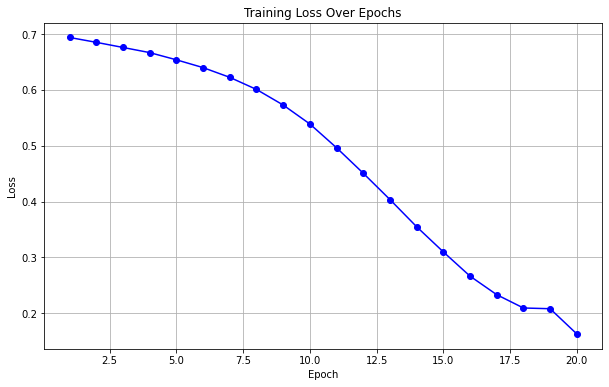

In [12]:
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Number of epochs
num_epochs = 20

# Define the model
# 30 input features
model = BreastCancerClassifier()

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# List to store the loss values
loss_values = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for x_batch, y_batch in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(x_batch)

        loss = criterion(y_pred, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Append the average loss to the loss_values list
    loss_values.append(avg_loss)

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [33]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
# Convert test data to PyTorch tensors (if not already)
x_test = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32)
y_test = torch.tensor(Y_test.values.astype(np.float32), dtype=torch.float32)

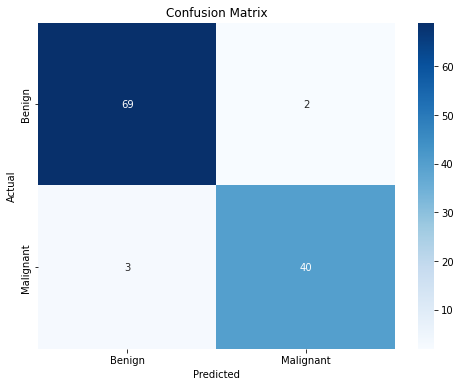

              precision    recall  f1-score   support

      Benign       0.96      0.97      0.97        71
   Malignant       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [46]:

# Disable gradient computation for evaluation
model.eval()
with torch.no_grad():
    # Get predictions
    test_predictions = model(x_test)
    test_predictions_binary = (test_predictions > 0.5).numpy().flatten()
    
# Convert test labels to numpy
y_test_binary = y_test.flatten()

# Create confusion matrix
cm = confusion_matrix(y_test_binary, test_predictions_binary)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print(classification_report(y_test_binary, test_predictions_binary, 
                             target_names=['Benign', 'Malignant']))

## Bayesian Optimization

Parameters:
1. Learning Rate
2. Feature Dimension of the Simple AFT (hidden_dim)
3. Number of neurons in fully connected layers - hidden1, hidden2


In [16]:
torch.manual_seed(42)
np.random.seed(42)

In [17]:
class AFTSimple(nn.Module):
    def __init__(self, max_seqlen, dim, hidden_dim=64):
        super().__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.to_q = nn.Linear(dim, hidden_dim)
        self.to_k = nn.Linear(dim, hidden_dim)
        self.to_v = nn.Linear(dim, hidden_dim)
        self.project = nn.Linear(hidden_dim, dim)
    
    def forward(self, x):
        B, T, _ = x.shape
        Q = self.to_q(x).view(B, T, self.hidden_dim)
        K = self.to_k(x).view(B, T, self.hidden_dim)
        V = self.to_v(x).view(B, T, self.hidden_dim)
        
        weights = torch.mul(torch.softmax(K, 1), V).sum(dim=1, keepdim=True)
        Q_sig = torch.sigmoid(Q)
        Yt = torch.mul(Q_sig, weights)
        Yt = Yt.view(B, T, self.hidden_dim)
        Yt = self.project(Yt)
        return Yt

    
class BreastCancerClassifier(nn.Module):
    def __init__(self, input_dim=30, hidden_dim=64, fc_layers=None):
        super().__init__()
        
        # AFT-style layer
        self.aft_layer = AFTSimple(max_seqlen=input_dim, dim=input_dim, hidden_dim=hidden_dim)

        # Dynamically create fully connected layers
        if fc_layers is None:
            fc_layers = [
                (input_dim, 64, nn.ReLU()),
                (64, 32, nn.ReLU()),
                (32, 1, nn.Sigmoid())
            ]
        layers = []
        for in_features, out_features, activation in fc_layers:
            layers.append(nn.Linear(in_features, out_features))
            layers.append(activation)
        
        self.fc_layers = nn.Sequential(*layers)
    
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        
        x = self.aft_layer(x)
        
        
        x = x.squeeze(1) if x.dim() > 2 else x
        
        return self.fc_layers(x)
    

In [18]:
def objective(trial):
    # Hyperparameters to optimize
    hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    # Dynamic FC layer configuration
    fc_layers = [
        (X_train.shape[1], trial.suggest_categorical('hidden1', [32, 64, 128]), nn.ReLU()),
        (trial.suggest_categorical('hidden1', [32, 64, 128]), trial.suggest_categorical('hidden2', [16, 32, 64]), nn.ReLU()),
        (trial.suggest_categorical('hidden2', [16, 32, 64]), 1, nn.Sigmoid())
    ]
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values.astype(np.float32), dtype = torch.float32)
    y_train_tensor = torch.tensor(y_train.values.astype(np.float32), dtype = torch.float32)
    X_val_tensor = torch.tensor(X_val.values.astype(np.float32), dtype = torch.float32)
    y_val_tensor = torch.tensor(y_val.values.astype(np.float32), dtype = torch.float32)
    
    
    # Create model, loss, and optimizer
    model = BreastCancerClassifier(input_dim=X_train.shape[1], hidden_dim = hidden_dim, fc_layers=fc_layers)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create the training dataset
    training_dataset = CustomDataset(X_train_tensor, y_train_tensor)

    # Example usage with DataLoader
    train_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)

    # Training
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_preds = (val_outputs > 0.5).float()
        accuracy = accuracy_score(y_val, val_preds.numpy())
        auc = roc_auc_score(y_val, val_outputs.numpy())
    
    # Report multiple metrics
    trial.set_user_attr('accuracy', accuracy)
    trial.set_user_attr('auc', auc)
    
    return val_loss.item()


In [48]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)
X = breast_cancer_wisconsin_diagnostic.data.features
Y = breast_cancer_wisconsin_diagnostic.data.targets
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), 
                        columns=X.columns, 
                        index=X.index)
# Assign the value of 1 to Malignant, assign 0 to Benign
Y.loc[:, 'Diagnosis'] = Y['Diagnosis'].map({'M': 1, 'B': 0})

# Split the data - 60/20/20 Train Validation Test Split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize', 
                             study_name='Breast Cancer Classifier Optimization')
study.optimize(objective, n_trials=50)

# Print results
print("Best trial:")
trial = study.best_trial
print(f"  Value (Val Loss): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Print additional metrics from the best trial
print("\nBest Trial Metrics:")
print(f"  Accuracy: {trial.user_attrs['accuracy']}")
print(f"  AUC: {trial.user_attrs['auc']}")


c:\users\jeremy tan\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
[I 2024-12-05 22:55:56,052] A new study created in memory with name: Breast Cancer Classifier Optimization
<ipython-input-18-e09bc8bbdd25>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
<ipython-input-6-1e5ce8616122>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceT

Best trial:
  Value (Val Loss): 0.11915985494852066
  Params: 
    hidden_dim: 32
    learning_rate: 0.00030483260875429415
    hidden1: 128
    hidden2: 32

Best Trial Metrics:
  Accuracy: 0.9649122807017544
  AUC: 0.9863636363636363


## Lastly, evaluate on the test set

In [49]:
best_hidden_dim = study.best_trial.params['hidden_dim']
best_learning_rate = study.best_trial.params['learning_rate'] 

best_fc_layers = [
    (X_train.shape[1], study.best_trial.params['hidden1'], nn.ReLU()),
    (study.best_trial.params['hidden1'], 
     study.best_trial.params['hidden2'], nn.ReLU()),
    (study.best_trial.params['hidden2'], 1, nn.Sigmoid())
]

In [50]:
print(best_hidden_dim)
print(best_learning_rate)
print(study.best_trial.params['hidden1'])
print(study.best_trial.params['hidden2'])


32
0.00030483260875429415
128
32


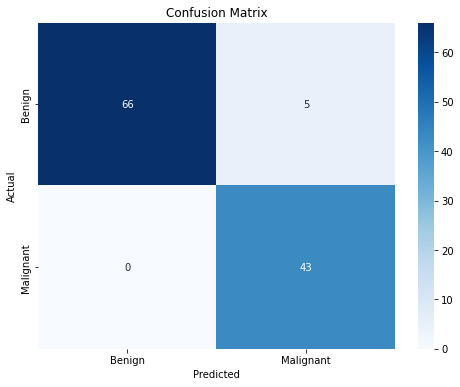

In [73]:
# Get the best trial's parameters
best_params = study.best_trial.params
best_hidden_dim = best_params['hidden_dim']
best_learning_rate = best_params['learning_rate']


# Reconstruct the best FC layers configuration
best_fc_layers = [
    (X_train.shape[1], best_params['hidden1'], nn.ReLU()),
    (best_params['hidden1'], 
     best_params['hidden2'], nn.ReLU()),
    (best_params['hidden2'], 1, nn.Sigmoid())
]

# Create the model with the best hyperparameters
best_model = BreastCancerClassifier(
    input_dim=X_train.shape[1], 
    hidden_dim = best_hidden_dim,
    fc_layers=best_fc_layers)

# Convert train and validation data to tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.astype(np.float32), dtype=torch.float32)

# Create optimizer with the best learning rate
optimizer = optim.Adam(best_model.parameters(), lr=best_learning_rate)
criterion = nn.BCELoss()

# Retrain the model with best hyperparameters
# Batching is not implemented. 
# The whole training dataset is processed in a single pass. 
num_epochs = 20
for epoch in range(num_epochs):
    best_model.train()
    optimizer.zero_grad()
    outputs = best_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Convert test data to tensors
X_test_tensor = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.astype(np.float32), dtype=torch.float32)

# Evaluate on test set
best_model.eval()
with torch.no_grad():
    # Predictions
    test_outputs = best_model(X_test_tensor)
    test_preds = (test_outputs > 0.5).float()
    
    # Calculate metrics
    test_loss = criterion(test_outputs, y_test_tensor)
    test_accuracy = accuracy_score(y_test, test_preds.numpy())
    test_auc = roc_auc_score(y_test, test_outputs.numpy())
    
# Confusion Matrix
cm = confusion_matrix(y_test, test_preds.numpy())

# Classification Report
class_report = classification_report(y_test, test_preds.numpy())

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [74]:
# Print results
print("\nTest Set Evaluation:")
print(f"Test Loss: {test_loss.item()}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(class_report)


Test Set Evaluation:
Test Loss: 0.6581778526306152
Test Accuracy: 0.956140350877193
Test AUC: 0.9921388797903701

Confusion Matrix:
[[66  5]
 [ 0 43]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        71
           1       0.90      1.00      0.95        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

